#Quantum Phase Classification using Quantum Convolutional Neural Networks (QCNN)

The primary goal of this project is to analyze the phase transitions of the Axial Next-Nearest-Neighbor Ising (ANNNI) model using a Quantum Convolutional Neural Network (QCNN).
## 1. The Model Hamiltonian
The model is defined by the following Hamiltonian:$$H = -J \sum_{i=1}^{N} \sigma_{x}^{i} \sigma_{x}^{i+1} - \kappa \sigma_{x}^{i} \sigma_{x}^{i+2} + h \sigma_{z}^{i}$$By fixing $J=1$, the system exhibits three distinct phases depending on the values of $\kappa$ and $h$:Ferromagnetic Antiphase Paramagnetic Our objective is to construct a QCNN capable of classifying these three phases using only the wavefunctions as input.

In [31]:
import cudaq
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from typing import List
import cupy as cp

In [32]:
cudaq.set_target("nvidia")
#cudaq.set_target("qpp-cpu")


In [33]:
# Setting our constants
num_qubits = 4 # Number of spins in the Hamiltonian (= number of qubits)
side = 8      # Discretization of the Phase Diagram


## 2. Data Preparation
To generate the training data, we perform Exact Diagonalization (ED) on the Hamiltonian to obtain the ground states. We then categorize these states into their respective phases based on established phase transition theories, storing them in an array called psis.Note: While ED is used here for educational purposes, practical research often employs methods like DMRG (Density Matrix Renormalization Group) for larger systems.For this session, we provide a pre-computed file psis48.npy. This contains wavefunctions for a 4-site system, with $\kappa$ ranging from $0.0$ to $1.0$ and $h$ ranging from $0.0$ to $2.0$, divided into an $8 \times 8$ grid.

In [34]:
def kt_transition(k):
    """Kosterlitz-Thouless transition line"""
    return 1.05 * np.sqrt((k - 0.5) * (k - 0.1))

def ising_transition(k):
    """Ising transition line"""
    return np.where(k == 0, 1, (1 - k) * (1 - np.sqrt((1 - 3 * k + 4 * k**2) / (1 - k))) / np.maximum(k, 1e-9))

def bkt_transition(k):
    """Floating Phase transition line"""
    return 1.05 * (k - 0.5)

def get_phase(k, h):
    """Get the phase from the DMRG transition lines"""
    # If under the Ising Transition Line (Left side)
    if k < .5 and h < ising_transition(k):
        return 0 # Ferromagnetic
    # If under the Kosterlitz-Thouless Transition Line (Right side)

    elif k > .5 and h < kt_transition(k):
        return 1 # Antiphase
    return 2 # else it is Paramagnetic

## 3. QCNN Architecture
The QCNN circuit operates by partitioning the system into 2-site blocks. The circuit is progressively reduced through mid-circuit measurements (pooling layers). Ultimately, Qubit 1 and Qubit 3 are used to classify the phases. We have defined the classification labels as follows:

00: Ferromagnetic

01: Antiphase

10: Paramagnetic

11: Trash class (Undefined)

In [35]:
ks = np.linspace(0, 1, side)
hs = np.linspace(0, 2, side)
K, H = np.meshgrid(ks, hs)

H_matrices = np.empty((len(ks), len(hs), 2**num_qubits, 2**num_qubits))
phases = np.empty((len(ks), len(hs)), dtype=int)

for x, k in enumerate(ks):
    for y, h in enumerate(hs):
        phases[y, x] = get_phase(k, h)  # Get the respective phase given k and h
psis=np.load('psis48.npy')
#psis=np.array(psis,dtype=np.complex64) using cpu
psis=cp.array(psis,dtype=np.complex64)  #using gpu

In [36]:
def count_bits(counts):
    c0 = counts["0"] if "0" in counts else 0
    c1 = counts["1"] if "1" in counts else 0
    denom = max(100, c0 + c1, 1)
    return c0 / denom, c1 / denom

In [37]:
@cudaq.kernel
def QCNN(state_vec:cudaq.State,params:np.array,num_qubits:int):
  qv = cudaq.qvector(state_vec)

  for i in range(0,num_qubits):
    ry(params[i],qv[i])

  cx(qv[0],qv[1])
  cx(qv[2],qv[3])

  for i in range(0,num_qubits):
    ry(params[i+num_qubits],qv[i])

  m_0=mz(qv[0])
  if m_0:
    rx(params[8],qv[1])
  else:
    rx(params[9],qv[1])

  m_2=mz(qv[2])
  if m_2:
    rx(params[10],qv[3])
  else:
    rx(params[11],qv[3])

  ry(params[12],qv[1])
  ry(params[13],qv[3])

  result1=mz(qv[1])
  result2=mz(qv[3])


def find_phase(state,params):
  sample_state=cudaq.State.from_data(state)
  sample_result=cudaq.sample(QCNN,sample_state,params,4,shots_count=100)
  O1=sample_result.get_register_counts("result1")
  O2=sample_result.get_register_counts("result2")
  p1_0, p1_1 = count_bits(O1)
  p2_0, p2_1 = count_bits(O2)

  p00 = p2_0 * p1_0
  p01 = p2_0 * p1_1
  p10 = p2_1 * p1_0
  p11 = p2_1 * p1_1

  p = np.array([p00, p01, p10, p11], dtype=float)

  s = float(p.sum())
  if s <= 0:
      p[:] = 0.25
  else:
      p /= s

  return p

params=np.random.rand(14)


def made_phase_li(params):
  phase_check=np.zeros([8,8,4])
  for i in range(0,8):
    for k in range(0,8):
      phase_check[i,k,:]=find_phase(psis[i,k],params)

  return phase_check


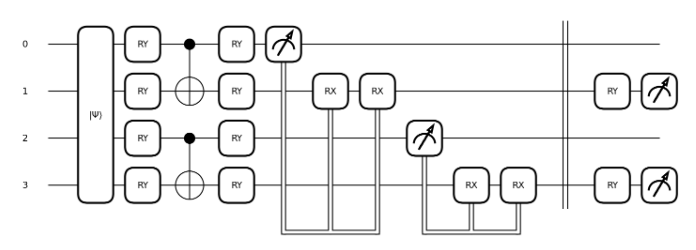

In [38]:
# Train data
analytical_mask = (K == 0) | (H == 0)
mask_indices = np.argwhere(analytical_mask)

## 4. Training and Optimization
We will use data points near $\kappa = 0$ and $h = 0$ as Train Data, where the exact phases are easily determined.To find the optimal parameters that maximize accuracy, various optimization functions can be utilized. While Adam is generally recommended for high-dimensional parameter spaces, we will use an alternative optimizer in this session due to time constraints.

In [39]:
X_train, Y_train = psis[analytical_mask], phases[analytical_mask]

In [40]:
def cross_entropy(y_pred):
  epsilon = 1e-9
  T=0.5
  Y=np.eye(4)[Y_train]
  pred = np.clip(y_pred, epsilon, 1 - epsilon)
  pred_sharpened = pred ** (1.0 / T)
  pred_sharpened = pred_sharpened / np.sum(pred_sharpened, axis=1, keepdims=True)
  loss = -np.sum(Y * np.log(pred_sharpened), axis=1)

  return np.mean(loss)

loss_li=[]
def loss_func(params):
  #check_phase=made_phase_li(params)
  #Y_prev=check_phase[analytical_mask]
  Y_prev=[]
  for i, k in mask_indices:
    Y_prev.append(find_phase(psis[i, k], params))
  Y_prev=np.array(Y_prev)
  ce=cross_entropy(Y_prev)
  loss_li.append(ce)
  print(ce)
  return ce




In [41]:
#optimizer=cudaq.optimizers.Adam()
#gradient=cudaq.gradients.ParameterShift() I recommend method

#optimizer = cudaq.optimizers.NelderMead()

optimizer = cudaq.optimizers.COBYLA()

"""
# Adam optimizer
def observe_function(parameter,gradient_strategy=gradient):
  get_result = lambda parameter_vector: loss_func(parameter_vector)
  cost=get_result(parameter)
  print(cost)
  cost_values.append(cost) #Option

  gradient_vector = gradient_strategy.compute(parameter,get_result,cost)
  return cost,gradient_vector
"""


'\n# Adam optimizer \ndef observe_function(parameter,gradient_strategy=gradient):\n  get_result = lambda parameter_vector: loss_func(parameter_vector)\n  cost=get_result(parameter)\n  print(cost)\n  cost_values.append(cost) #Option\n\n  gradient_vector = gradient_strategy.compute(parameter,get_result,cost)\n  return cost,gradient_vector\n'

In [42]:
init_para = np.array([ 1.4170905e+00,  1.3e+00, -2.6e-01, -2.0e-01, 5.0221309e-02,-8.0e-01, -1.0e-01,  2.0e-01, 3.1e+00, -2.0e-03,  8.0e-03,-3.1e+00, 5.8e-01, -8.0e-01], dtype=float)
optimizer.max_iterations=240
optimizer.initial_parameters=np.array(init_para)
optimal_expectation, optimal_parameters = optimizer.optimize(dimensions=14, function=loss_func)
#energy_kreo,parameter_kreo=optimizer.optimize(dimensions=34,function=observe_function) Adam optimizer


1.5812878069362593
2.9687945384556733
2.3330363143562094
2.0406572627672617
2.1117337923677555
3.562502769265582
2.053810987988411
1.7070344845065455
2.080386961762195
1.5349340760169174
1.9818622791819456
1.6401482677873898
1.5749300845199374
2.2722422566156024
1.8611940336052244
1.452807722331383
1.726605749302051
1.4112350607672457
1.8270804567272423
1.4622168384816805
0.9971642050055524
1.079558526113802
1.0216425299394643
1.3121618096438887
1.0082739810975712
1.2161534827526557
0.9303751095269225
0.9166662206210645
0.807184226931576
0.874196118929426
0.9923087674038202
0.8159229976000653
0.7773926487634107
0.7364677082319963
0.8231737152653843
0.9058170571233737
0.8536383117132128
1.1641734921159397
1.0413425363918916
0.6201639736708436
0.7136324586094508
0.6118318015378219
0.7156755629886199
0.7261743185926407
0.6823788070261465
0.6268340142581735
0.6226586673241581
0.6777707145842904
0.6477078940266572
0.7172555086884078
0.6762313774731697
0.7870891754411135
0.7315363979245312
0

## 5. Results
The following is the Phase Diagram generated by our trained QCNN:

Text(0, 0.5, 'loss')

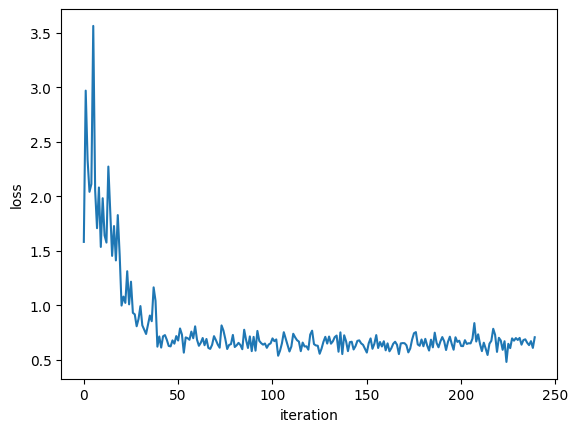

In [47]:
plt.plot(loss_li)
plt.xlabel("iteration")
plt.ylabel("loss")

In [48]:
find_QCNN_phase=made_phase_li(optimal_parameters)
QCNN_phase = np.argmax(find_QCNN_phase, axis=-1)

print(QCNN_phase)

[[0 1 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 0]
 [2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2]]


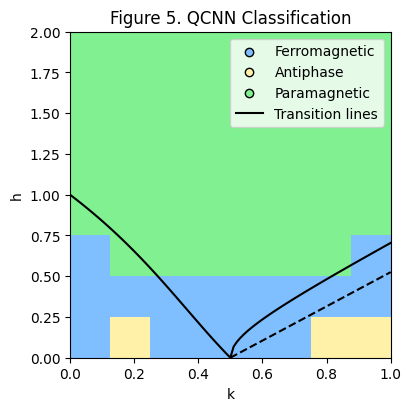

In [49]:
phase_labels = ["Ferromagnetic", "Antiphase", "Paramagnetic", "Trash Class",]
colors = ['#80bfff', '#fff2a8',  '#80f090', '#da8080',]

cmap = ListedColormap(colors)

bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(4,4), constrained_layout=True)
plt.imshow(
    QCNN_phase,
    cmap=cmap,
    norm=norm,
    aspect="auto",
    origin="lower",
    extent=[0, 1, 0, 2]
)

# Plot the transition lines (Ising and KT) for reference.
k_vals1 = np.linspace(0.0, 0.5, 50)
k_vals2 = np.linspace(0.5, 1.0, 50)
plt.plot(k_vals1, ising_transition(k_vals1), 'k')
plt.plot(k_vals2, kt_transition(k_vals2), 'k')
plt.plot(k_vals2, bkt_transition(k_vals2), 'k', ls = '--')

for color, phase in zip(colors, phase_labels[:-1]):
    plt.scatter([], [], color=color, label=phase, edgecolors='black')
plt.plot([], [], 'k', label='Transition lines')

plt.xlabel("k"), plt.ylabel("h")
plt.title("Figure 5. QCNN Classification")
plt.legend()
plt.show()

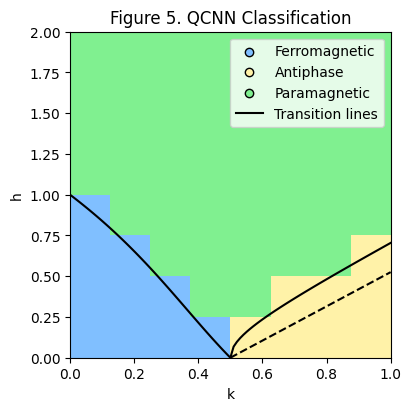

In [50]:
phase_labels = ["Ferromagnetic", "Antiphase", "Paramagnetic", "Trash Class",]
cmap = ListedColormap(colors)

bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(4,4), constrained_layout=True)
plt.imshow(
    phases,
    cmap=cmap,
    norm=norm,
    aspect="auto",
    origin="lower",
    extent=[0, 1, 0, 2]
)

# Plot the transition lines (Ising and KT) for reference.
k_vals1 = np.linspace(0.0, 0.5, 50)
k_vals2 = np.linspace(0.5, 1.0, 50)
plt.plot(k_vals1, ising_transition(k_vals1), 'k')
plt.plot(k_vals2, kt_transition(k_vals2), 'k')
plt.plot(k_vals2, bkt_transition(k_vals2), 'k', ls = '--')

for color, phase in zip(colors, phase_labels[:-1]):
    plt.scatter([], [], color=color, label=phase, edgecolors='black')
plt.plot([], [], 'k', label='Transition lines')

plt.xlabel("k"), plt.ylabel("h")
plt.title("Figure 5. QCNN Classification")
plt.legend()
plt.show()

### reference
1.https://pennylane.ai/qml/demos/tutorial_annni